<a href="https://colab.research.google.com/github/franciseven/trabalho_SBEC/blob/main/upsampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.8 MB/s eta 0:00:00


In [204]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    matthews_corrcoef,
    confusion_matrix,
    roc_curve,
    classification_report
)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/SBEC-SEPSI/data/Dataset.csv')
df.drop(columns=['Unnamed: 0','EtCO2','BaseExcess','Fibrinogen', 'Unit1', 'Unit2', 'Lactate','TroponinI','Alkalinephos','AST','Bilirubin_direct', 'Bilirubin_total','SaO2'], inplace=True)
df.head(10)

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,HCO3,FiO2,...,Hgb,PTT,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,68.54,0,-0.02,1,0,17072
1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,0.4,...,NaN,NaN,NaN,NaN,68.54,0,-0.02,2,0,17072
2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,68.54,0,-0.02,3,0,17072
3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,NaN,...,NaN,NaN,NaN,NaN,68.54,0,-0.02,4,0,17072
4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,26.0,0.4,...,9.5,30.6,11.3,330.0,68.54,0,-0.02,5,0,17072
5,5,62.0,100.0,NaN,124.0,85.0,61.0,14.0,NaN,0.4,...,NaN,NaN,NaN,NaN,68.54,0,-0.02,6,0,17072
6,6,61.0,100.0,NaN,101.0,75.0,58.0,14.0,NaN,NaN,...,NaN,NaN,NaN,NaN,68.54,0,-0.02,7,0,17072
7,7,68.0,100.0,35.78,142.0,93.5,78.0,16.0,NaN,NaN,...,NaN,NaN,NaN,NaN,68.54,0,-0.02,8,0,17072
8,8,71.0,100.0,NaN,121.0,74.0,91.0,14.0,NaN,0.5,...,NaN,NaN,NaN,NaN,68.54,0,-0.02,9,0,17072
9,9,69.0,100.0,NaN,120.0,79.0,98.0,14.0,NaN,NaN,...,NaN,NaN,NaN,NaN,68.54,0,-0.02,10,0,17072


In [ ]:
## Data information

In [ ]:
len(df['Patient_ID'].unique())

40336

In [ ]:
df['Patient_ID'].value_counts()

,count
Patient_ID,
18469,336
113190,336
4905,336
101922,336
116439,336
...,...
115587,8
116503,8
111396,8


In [ ]:
df.isna().sum()

,0
Hour,0
HR,153399
O2Sat,202736
Temp,1026984
SBP,226265
MAP,193270
DBP,486554
Resp,238335
HCO3,1487182
FiO2,1422845


## Data split

In [ ]:
unique_ids = df['Patient_ID'].unique()

In [ ]:
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)

train_df = df[df['Patient_ID'].isin(train_ids)].copy()
test_df = df[df['Patient_ID'].isin(test_ids)].copy()

X_train = train_df.drop('SepsisLabel', axis=1)
y_train = train_df[['Patient_ID','Hour','SepsisLabel']].copy()

X_test = test_df.drop('SepsisLabel', axis=1)
y_test = test_df[['Patient_ID','Hour','SepsisLabel']].copy()

## Upsampling

In [ ]:
def weighted_fillna(df, cols):
    """
    Preenche os valores NaN entre dois valores conhecidos usando média ponderada.
    """

    for col in cols:
        mask = df[col].isna()
        if mask.sum() == 0:
            continue

        idx_known_value = np.where(~mask)[0]

        if len(idx_known_value) < 2:
            continue

        for i in range(len(idx_known_value) - 1):
            start_value = idx_known_value[i]
            end_value =  idx_known_value[i+1]

            start_value = df.iloc[start_value][col]
            end_value = df.iloc[end_value][col]

            idx_nan_iloc = np.arange(start_value + 1, end_value)
            weighted_sum = len(idx_nan_iloc) + 1

            for j, idx_nan in enumerate(idx_nan_iloc, 1):
                weight1 = (weighted_sum - j) / weighted_sum
                weight2 = j / weighted_sum
                df.iloc[idx_nan, df.columns.get_loc(col)] = (start_value * weight1) + (end_value * weight2)

    return df

In [ ]:
cols = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'HCO3', 'FiO2',
        'pH', 'PaCO2', 'BUN', 'Calcium', 'Chloride', 'Creatinine', 'Glucose',
        'Magnesium', 'Phosphate', 'Potassium', 'Hct', 'Hgb', 'PTT', 'WBC',
        'Platelets']

In [ ]:
X_train = X_train.groupby("Patient_ID", group_keys=False).apply(lambda x: weighted_fillna(x, cols))

<ipython-input-87-d1534a2bee30>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  X_train = X_train.groupby("Patient_ID", group_keys=False).apply(lambda x: weighted_fillna(x, cols))


In [ ]:
X_test = X_test.groupby("Patient_ID", group_keys=False).apply(lambda x: weighted_fillna(x, cols))

<ipython-input-13-5f3978138e1d>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  X_test = X_test.groupby("Patient_ID", group_keys=False).apply(lambda x: weighted_fillna(x, cols))


In [ ]:
X_train = X_train.groupby("Patient_ID", group_keys=False).apply(lambda x: x.fillna(method='bfill'))  # Preenche os primeiros NaNs
X_train = X_train.groupby("Patient_ID", group_keys=False).apply(lambda x: x.fillna(method='ffill'))  # Preenche os últimos NaNs

<ipython-input-88-f59e92f0d9ee>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_train = X_train.groupby("Patient_ID", group_keys=False).apply(lambda x: x.fillna(method='bfill'))  # Preenche os primeiros NaNs
<ipython-input-88-f59e92f0d9ee>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  X_train = X_train.groupby("Patient_ID", group_keys=False).apply(lambda x: x.fillna(method='bfill'))  # Preenche os primeiros NaNs
<ipython-input-88-f59e92f0d9ee>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_train = X_train.

In [ ]:
X_test

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,HCO3,FiO2,...,Hct,Hgb,PTT,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,Patient_ID
43,0,75.5,95.0,37.4400,135.0,88.33,NaN,24.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,46.32,1,-0.04,4,16153
44,1,84.0,95.0,37.2200,124.0,81.33,NaN,22.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,46.32,1,-0.04,5,16153
45,2,89.0,96.0,37.1925,132.0,84.00,NaN,24.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,46.32,1,-0.04,6,16153
46,3,85.0,95.0,37.1650,140.0,87.33,NaN,22.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,46.32,1,-0.04,7,16153
47,4,83.0,94.0,37.1375,108.0,76.67,NaN,21.0,25.0,NaN,...,35.4,12.7,25.3,12.8,260.0,46.32,1,-0.04,8,16153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552051,51,76.0,98.0,37.2000,89.0,63.00,44.0,18.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,62.00,0,-3.19,52,116212
1552052,52,77.0,97.5,37.0000,92.0,68.00,50.0,17.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,62.00,0,-3.19,53,116212
1552053,53,72.0,95.0,37.0000,104.0,72.00,51.0,18.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,62.00,0,-3.19,54,116212
1552054,54,71.0,99.0,NaN,98.0,65.00,45.0,15.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,62.00,0,-3.19,55,116212


In [ ]:
X_test[X_test['Patient_ID'] == 16153]

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,HCO3,FiO2,...,Hct,Hgb,PTT,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,Patient_ID
43,0,75.5,95.0,37.4400,135.0,88.330,NaN,24.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,46.32,1,-0.04,4,16153
44,1,84.0,95.0,37.2200,124.0,81.330,NaN,22.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,46.32,1,-0.04,5,16153
45,2,89.0,96.0,37.1925,132.0,84.000,NaN,24.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,46.32,1,-0.04,6,16153
46,3,85.0,95.0,37.1650,140.0,87.330,NaN,22.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,46.32,1,-0.04,7,16153
47,4,83.0,94.0,37.1375,108.0,76.670,NaN,21.0,25.0,NaN,...,35.4,12.7,25.3,12.8,260.0,46.32,1,-0.04,8,16153
48,5,90.0,94.0,37.1100,124.0,85.330,NaN,24.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,46.32,1,-0.04,9,16153
49,6,89.0,94.0,37.1250,121.0,80.330,NaN,19.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,46.32,1,-0.04,10,16153
50,7,86.0,95.0,37.1400,135.0,87.000,NaN,24.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,46.32,1,-0.04,11,16153
51,8,84.0,94.0,37.1550,130.0,89.330,NaN,21.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,46.32,1,-0.04,12,16153
52,9,88.0,95.0,37.1700,124.0,84.670,NaN,19.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,46.32,1,-0.04,13,16153


In [ ]:
X_test = X_test.groupby("Patient_ID", group_keys=False).apply(lambda x: x.fillna(method='bfill'))  # Preenche os primeiros NaNs
X_test = X_test.groupby("Patient_ID", group_keys=False).apply(lambda x: x.fillna(method='ffill'))  # Preenche os últimos NaNs

<ipython-input-16-0dfb022c4bf4>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test = X_test.groupby("Patient_ID", group_keys=False).apply(lambda x: x.fillna(method='bfill'))  # Preenche os primeiros NaNs
<ipython-input-16-0dfb022c4bf4>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  X_test = X_test.groupby("Patient_ID", group_keys=False).apply(lambda x: x.fillna(method='bfill'))  # Preenche os primeiros NaNs
<ipython-input-16-0dfb022c4bf4>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test = X_test.groupb

## Save upsampling

In [ ]:
#X_train.to_csv('/content/drive/MyDrive/SBEC-SEPSI/data/X_train3.csv', index=False)

In [ ]:
#y_train.to_csv('/content/drive/MyDrive/SBEC-SEPSI/data/y_train3.csv', index=False)

In [ ]:
#X_test.to_csv('/content/drive/MyDrive/SBEC-SEPSI/data/X_test3.csv', index=False)

In [ ]:
#y_test.to_csv('/content/drive/MyDrive/SBEC-SEPSI/data/y_test3.csv', index=False)

In [ ]:
X_train[X_train['Patient_ID'] == 10355]

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,HCO3,FiO2,...,Hct,Hgb,PTT,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,Patient_ID
311,0,91.0,97.5,37.500000,95.0,69.0,55.0,9.5,22.0,0.5,...,31.0,10.8,35.400000,3.7,40.0,86.26,1,-109.88,1,10355
312,1,91.0,97.5,37.500000,95.0,69.0,55.0,9.5,22.0,0.5,...,31.0,10.8,35.400000,3.7,40.0,86.26,1,-109.88,2,10355
313,2,89.5,98.5,37.500000,114.5,83.5,64.5,11.0,22.0,0.5,...,31.0,10.8,35.589474,3.7,40.0,86.26,1,-109.88,3,10355
314,3,99.0,97.0,37.276667,108.0,76.0,59.0,13.0,22.0,0.5,...,31.0,10.8,35.778947,3.7,40.0,86.26,1,-109.88,4,10355
315,4,97.0,97.0,37.053333,107.0,74.0,58.0,13.0,22.0,0.5,...,31.0,10.8,35.968421,3.7,40.0,86.26,1,-109.88,5,10355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,71,112.0,97.5,36.390000,79.5,58.0,48.0,31.5,19.0,0.6,...,29.1,10.2,45.600000,7.8,62.0,86.26,1,-109.88,72,10355
383,72,115.0,96.0,36.500000,86.0,62.0,49.0,31.0,19.0,0.6,...,29.1,10.2,45.600000,7.8,62.0,86.26,1,-109.88,73,10355
384,73,109.0,96.0,36.610000,91.0,64.0,50.0,28.0,19.0,0.6,...,29.1,10.2,45.600000,7.8,62.0,86.26,1,-109.88,74,10355
385,74,113.0,97.0,36.720000,75.0,58.0,48.0,31.0,19.0,0.6,...,29.1,10.2,45.600000,7.8,62.0,86.26,1,-109.88,75,10355


In [ ]:
y_train[y_train['Patient_ID'] == 10355]

,Patient_ID,Hour,SepsisLabel
311,10355,0,0
312,10355,1,0
313,10355,2,0
314,10355,3,0
315,10355,4,0
...,...,...,...
382,10355,71,1
383,10355,72,1
384,10355,73,1
385,10355,74,1


In [ ]:
y_train[y_train['Patient_ID'] == 10]

,Patient_ID,Hour,SepsisLabel
642888,10,0,0
642889,10,1,0
642890,10,2,0
642891,10,3,0
642892,10,4,0
642893,10,5,0
642894,10,6,0
642895,10,7,0
642896,10,8,0
642897,10,9,0


## Load upsampling Data

dataset com upsampling, mas algumas colunas sao so nan, nao foi tirado as linhas com sepsi e nao padronizou o tamanho de linhas

In [244]:
X_train_ = pd.read_csv('/content/drive/MyDrive/SBEC-SEPSI/data/X_train3.csv')
y_train_ = pd.read_csv('/content/drive/MyDrive/SBEC-SEPSI/data/y_train3.csv')
X_train_.head(10)

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,HCO3,FiO2,...,Hct,Hgb,PTT,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,Patient_ID
0,0,65.0,100.0,35.7800,129.0,72.00,69.0,16.50,26.0,0.400000,...,29.700000,9.500000,30.6,11.300000,330.0,68.54,0,-0.02,1,17072
1,1,65.0,100.0,35.7800,129.0,72.00,69.0,16.50,26.0,0.400000,...,29.700000,9.500000,30.6,11.300000,330.0,68.54,0,-0.02,2,17072
2,2,78.0,100.0,35.7800,129.0,42.50,69.0,16.75,26.0,0.400000,...,29.700000,9.500000,30.6,11.300000,330.0,68.54,0,-0.02,3,17072
3,3,73.0,100.0,35.7800,129.0,58.25,69.0,17.00,26.0,0.400000,...,29.700000,9.500000,30.6,11.300000,330.0,68.54,0,-0.02,4,17072
4,4,70.0,100.0,35.7800,129.0,74.00,69.0,14.00,26.0,0.400000,...,29.700000,9.500000,30.6,11.300000,330.0,68.54,0,-0.02,5,17072
5,5,62.0,100.0,35.7800,124.0,85.00,61.0,14.00,26.0,0.400000,...,29.755556,9.555556,30.6,11.266667,327.0,68.54,0,-0.02,6,17072
6,6,61.0,100.0,35.7800,101.0,75.00,58.0,14.00,26.0,0.433333,...,29.811111,9.611111,30.6,11.233333,324.0,68.54,0,-0.02,7,17072
7,7,68.0,100.0,35.7800,142.0,93.50,78.0,16.00,26.0,0.466667,...,29.866667,9.666667,30.6,11.200000,321.0,68.54,0,-0.02,8,17072
8,8,71.0,100.0,35.9325,121.0,74.00,91.0,14.00,26.0,0.500000,...,29.922222,9.722222,30.6,11.166667,318.0,68.54,0,-0.02,9,17072
9,9,69.0,100.0,36.0850,120.0,79.00,98.0,14.00,26.0,0.500000,...,29.977778,9.777778,30.6,11.133333,315.0,68.54,0,-0.02,10,17072


In [245]:
X_test_ = pd.read_csv('/content/drive/MyDrive/SBEC-SEPSI/data/X_test3.csv')
y_test_ = pd.read_csv('/content/drive/MyDrive/SBEC-SEPSI/data/y_test3.csv')
X_test_

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,HCO3,FiO2,...,Hct,Hgb,PTT,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,Patient_ID
0,0,75.5,95.0,37.4400,135.0,88.33,NaN,24.5,25.0,NaN,...,35.4,12.7,25.3,12.8,260.0,46.32,1,-0.04,4,16153
1,1,84.0,95.0,37.2200,124.0,81.33,NaN,22.0,25.0,NaN,...,35.4,12.7,25.3,12.8,260.0,46.32,1,-0.04,5,16153
2,2,89.0,96.0,37.1925,132.0,84.00,NaN,24.0,25.0,NaN,...,35.4,12.7,25.3,12.8,260.0,46.32,1,-0.04,6,16153
3,3,85.0,95.0,37.1650,140.0,87.33,NaN,22.0,25.0,NaN,...,35.4,12.7,25.3,12.8,260.0,46.32,1,-0.04,7,16153
4,4,83.0,94.0,37.1375,108.0,76.67,NaN,21.0,25.0,NaN,...,35.4,12.7,25.3,12.8,260.0,46.32,1,-0.04,8,16153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309988,51,76.0,98.0,37.2000,89.0,63.00,44.0,18.0,NaN,0.32,...,32.2,10.0,NaN,5.0,113.0,62.00,0,-3.19,52,116212
309989,52,77.0,97.5,37.0000,92.0,68.00,50.0,17.5,NaN,0.32,...,32.2,10.0,NaN,5.0,113.0,62.00,0,-3.19,53,116212
309990,53,72.0,95.0,37.0000,104.0,72.00,51.0,18.0,NaN,0.32,...,32.2,10.0,NaN,5.0,113.0,62.00,0,-3.19,54,116212
309991,54,71.0,99.0,37.0000,98.0,65.00,45.0,15.0,NaN,0.32,...,32.2,10.0,NaN,5.0,113.0,62.00,0,-3.19,55,116212


## Data cleaning

### Delete sepsi and adapt label

tirando as linhas com sepsi (1) e transformando labels das pessoas que tem sepsi como 1

In [246]:
def preprocess_sepsis_data(X, y):
    """
    Pré-processa os dados para manter apenas as linhas antes do evento de sepse
    (ou todas exceto a última se não houver evento), e marca como 1 todas as
    linhas anteriores ao evento em pacientes com SepsisLabel == 1.
    """

    lines_to_remain = []

    for pacient_id, group in y.groupby('Patient_ID'):
        if group['SepsisLabel'].any():
            event_line = group[group['SepsisLabel'] == 1].index[0]
            valid_line = group.index[group.index < event_line].tolist()
            lines_to_remain.extend(valid_line)
            y.loc[valid_line, 'SepsisLabel'] = 1
        else:
            lines_to_remain.extend(group.index[:-1].tolist())

    X_filtered = X.loc[lines_to_remain].reset_index(drop=True)
    y_filtered = y.loc[lines_to_remain].reset_index(drop=True)

    return X_filtered, y_filtered

In [247]:
X_train_, y_train_ = preprocess_sepsis_data(X_train_, y_train_)

In [248]:
X_test_, y_test_ = preprocess_sepsis_data(X_test_, y_test_)

In [249]:
y_train_[y_train_['Patient_ID'] == 10355]

,Patient_ID,Hour,SepsisLabel
306285,10355,0,1
306286,10355,1,1
306287,10355,2,1
306288,10355,3,1
306289,10355,4,1
...,...,...,...
306346,10355,61,1
306347,10355,62,1
306348,10355,63,1
306349,10355,64,1


In [250]:
X_train_[X_train_['Patient_ID'] == 10355]

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,HCO3,FiO2,...,Hct,Hgb,PTT,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,Patient_ID
306285,0,91.0,97.5,37.500000,95.0,69.0,55.0,9.5,22.0,0.5,...,31.0,10.8,35.400000,3.7,40.0,86.26,1,-109.88,1,10355
306286,1,91.0,97.5,37.500000,95.0,69.0,55.0,9.5,22.0,0.5,...,31.0,10.8,35.400000,3.7,40.0,86.26,1,-109.88,2,10355
306287,2,89.5,98.5,37.500000,114.5,83.5,64.5,11.0,22.0,0.5,...,31.0,10.8,35.589474,3.7,40.0,86.26,1,-109.88,3,10355
306288,3,99.0,97.0,37.276667,108.0,76.0,59.0,13.0,22.0,0.5,...,31.0,10.8,35.778947,3.7,40.0,86.26,1,-109.88,4,10355
306289,4,97.0,97.0,37.053333,107.0,74.0,58.0,13.0,22.0,0.5,...,31.0,10.8,35.968421,3.7,40.0,86.26,1,-109.88,5,10355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306346,61,127.0,91.0,36.752500,136.0,98.0,79.0,31.0,19.0,0.6,...,29.1,10.2,45.600000,7.8,16.1,86.26,1,-109.88,62,10355
306347,62,128.5,92.0,36.560000,107.0,81.5,67.0,30.0,19.0,0.6,...,29.1,10.2,45.600000,7.8,21.2,86.26,1,-109.88,63,10355
306348,63,126.0,94.0,36.545000,118.0,87.0,71.0,32.0,19.0,0.6,...,29.1,10.2,45.600000,7.8,26.3,86.26,1,-109.88,64,10355
306349,64,102.0,94.0,36.530000,98.0,61.0,45.0,32.0,19.0,0.6,...,29.1,10.2,45.600000,7.8,31.4,86.26,1,-109.88,65,10355


### Data slicing

padronizando o tamanho dependendo das windows (tirando parte a prior e deixando observer)

In [99]:
def cut_window(df_train, df_label, window_ob, window_prior):

    if len(df_train) == len(df_label):
        size_min = window_ob + window_prior

        df_train = df_train.groupby('Patient_ID').filter(lambda g: len(g) >= size_min)
        df_label = df_label.loc[df_train.index]

        def slice_group(df_group):
            return df_group.iloc[-(window_ob + window_prior): -window_prior]

        df_train = df_train.groupby('Patient_ID', group_keys=False).apply(slice_group)
        df_label = df_label.loc[df_train.index]

        return df_train, df_label
    else:
        print("DataFrames have different sizes.")

        return None, None

In [100]:
X_train_, y_train_ = cut_window(X_train_, y_train_, 4, 2)

<ipython-input-99-a743d54c5145>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train = df_train.groupby('Patient_ID', group_keys=False).apply(slice_group)


In [101]:
X_test_, y_test_ = cut_window(X_test_, y_test_, 4, 2)

<ipython-input-99-a743d54c5145>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train = df_train.groupby('Patient_ID', group_keys=False).apply(slice_group)


In [102]:
len(y_test_)

31644

In [103]:
len(X_test_)

31644

In [104]:
total_nans = X_test_.isna().sum().sum()
print(total_nans)

134636


In [105]:
total_nans = X_train_.isna().sum().sum()
print(total_nans)

553688


### NaN treating

tirando pacientes com colunas com nans

In [106]:
def remove_nan_pacient(X, y):
    """
    Remove pacientes que ainda tem nan (coluna de nan).
    """
    X = X.groupby('Patient_ID').filter(lambda g: not g.isna().any().any())

    ids_remain = X['Patient_ID'].unique()
    y = y[y['Patient_ID'].isin(ids_remain)]

    return X, y

In [107]:
X_train_, y_train_ = remove_nan_pacient(X_train_, y_train_)

In [108]:
X_test_, y_test_ = remove_nan_pacient(X_test_, y_test_)

### Data Visualization and sort data

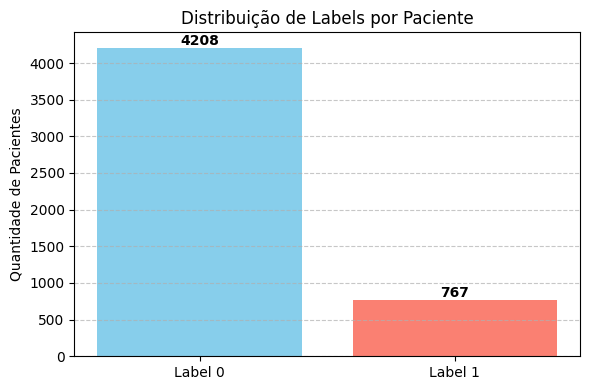

In [113]:
pacientes_rotulados = y_train_.groupby('Patient_ID').first().reset_index()

label_counts = pacientes_rotulados['SepsisLabel'].value_counts().sort_index()

plt.figure(figsize=(6,4))
bars = plt.bar(label_counts.index.astype(str), label_counts.values, color=['skyblue', 'salmon'])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{int(height)}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xticks([0, 1], ['Label 0', 'Label 1'])
plt.ylabel('Quantidade de Pacientes')
plt.title('Distribuição de Labels por Paciente')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

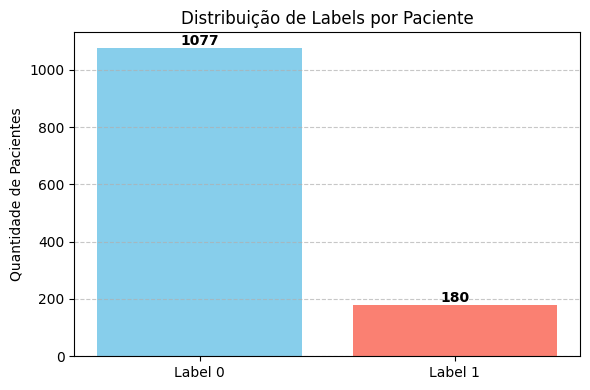

In [114]:
pacientes_rotulados = y_test_.groupby('Patient_ID').first().reset_index()

label_counts = pacientes_rotulados['SepsisLabel'].value_counts().sort_index()

plt.figure(figsize=(6,4))
bars = plt.bar(label_counts.index.astype(str), label_counts.values, color=['skyblue', 'salmon'])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{int(height)}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xticks([0, 1], ['Label 0', 'Label 1'])
plt.ylabel('Quantidade de Pacientes')
plt.title('Distribuição de Labels por Paciente')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [115]:
X_train_ = X_train_.sort_values(by=['Patient_ID', 'Hour'])
y_train_ = y_train_.sort_values(by=['Patient_ID', 'Hour'])


X_test_ = X_test_.sort_values(by=['Patient_ID', 'Hour'])
y_test_ = y_test_.sort_values(by=['Patient_ID', 'Hour'])

In [116]:
X_train_

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,HCO3,FiO2,...,Hct,Hgb,PTT,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,Patient_ID
580710,42,72.0,97.0,37.0600,151.0,92.0,63.0,28.0,29.000000,0.8,...,32.10,11.0,29.5,8.7,486.000000,45.82,0,-1195.71,43,3
580711,43,72.0,95.0,37.0725,159.0,99.0,69.0,24.0,29.000000,0.8,...,32.10,11.0,29.5,8.7,486.000000,45.82,0,-1195.71,44,3
580712,44,72.0,99.0,37.0850,158.0,98.0,68.0,26.0,29.000000,0.8,...,32.10,11.0,29.5,8.7,486.000000,45.82,0,-1195.71,45,3
580713,45,72.0,99.0,37.0975,139.0,84.0,54.0,26.0,29.000000,0.8,...,32.10,11.0,29.5,8.7,486.000000,45.82,0,-1195.71,46,3
489471,39,112.0,96.0,38.3900,111.0,76.0,61.5,14.0,18.571429,0.4,...,36.95,14.5,27.1,8.8,43.285714,64.24,1,-0.05,40,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842237,88,88.0,97.0,37.7000,109.0,73.0,51.5,18.0,20.700000,0.5,...,29.80,10.4,33.9,11.1,95.000000,79.00,0,-97.62,89,119842
949287,15,72.0,92.0,37.2000,137.0,83.0,67.0,16.0,22.600000,0.4,...,29.30,9.9,25.4,9.5,184.000000,62.00,1,-69.92,21,119870
949288,16,72.5,93.0,37.3000,128.5,76.5,61.0,18.0,22.600000,0.4,...,29.30,9.9,25.4,9.5,184.000000,62.00,1,-69.92,22,119870
949289,17,76.0,95.0,37.3000,138.0,82.0,65.0,18.0,22.600000,0.4,...,29.30,9.9,25.4,9.5,184.000000,62.00,1,-69.92,23,119870


## Set variables

In [253]:
n_pacientes = X_train_['Patient_ID'].nunique()
window_ob = 4
n_features = len(X_train_.columns) - 2 #id e hour

## NORMALIZATION

In [118]:
X_train_

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,HCO3,FiO2,...,Hct,Hgb,PTT,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,Patient_ID
580710,42,72.0,97.0,37.0600,151.0,92.0,63.0,28.0,29.000000,0.8,...,32.10,11.0,29.5,8.7,486.000000,45.82,0,-1195.71,43,3
580711,43,72.0,95.0,37.0725,159.0,99.0,69.0,24.0,29.000000,0.8,...,32.10,11.0,29.5,8.7,486.000000,45.82,0,-1195.71,44,3
580712,44,72.0,99.0,37.0850,158.0,98.0,68.0,26.0,29.000000,0.8,...,32.10,11.0,29.5,8.7,486.000000,45.82,0,-1195.71,45,3
580713,45,72.0,99.0,37.0975,139.0,84.0,54.0,26.0,29.000000,0.8,...,32.10,11.0,29.5,8.7,486.000000,45.82,0,-1195.71,46,3
489471,39,112.0,96.0,38.3900,111.0,76.0,61.5,14.0,18.571429,0.4,...,36.95,14.5,27.1,8.8,43.285714,64.24,1,-0.05,40,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842237,88,88.0,97.0,37.7000,109.0,73.0,51.5,18.0,20.700000,0.5,...,29.80,10.4,33.9,11.1,95.000000,79.00,0,-97.62,89,119842
949287,15,72.0,92.0,37.2000,137.0,83.0,67.0,16.0,22.600000,0.4,...,29.30,9.9,25.4,9.5,184.000000,62.00,1,-69.92,21,119870
949288,16,72.5,93.0,37.3000,128.5,76.5,61.0,18.0,22.600000,0.4,...,29.30,9.9,25.4,9.5,184.000000,62.00,1,-69.92,22,119870
949289,17,76.0,95.0,37.3000,138.0,82.0,65.0,18.0,22.600000,0.4,...,29.30,9.9,25.4,9.5,184.000000,62.00,1,-69.92,23,119870


In [119]:
cols = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'HCO3',
       'FiO2', 'pH', 'PaCO2', 'BUN', 'Calcium', 'Chloride', 'Creatinine',
       'Glucose', 'Magnesium', 'Phosphate', 'Potassium', 'Hct', 'Hgb', 'PTT',
       'WBC', 'Platelets', 'Age', 'HospAdmTime', 'ICULOS']

scale_train = MinMaxScaler(feature_range=(0,1))

X_train = X_train_.copy()
X_train[cols] = scale_train.fit_transform(X_train_[cols])
X_train = pd.DataFrame(X_train, columns=X_train_.columns)

scale_test = MinMaxScaler(feature_range=(0,1))

X_test = X_test_.copy()
X_test[cols] = scale_train.fit_transform(X_test_[cols])
X_test = pd.DataFrame(X_test, columns=X_test_.columns)

In [32]:
X_train

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,HCO3,FiO2,...,Hct,Hgb,PTT,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,Patient_ID
580710,42,0.300000,0.962025,0.786215,0.623762,0.256318,0.250000,0.457627,0.547619,0.114286,...,0.490526,0.451429,0.070133,0.062455,0.478478,0.390887,0,0.773746,0.120846,3
580711,43,0.300000,0.936709,0.786945,0.663366,0.281588,0.284884,0.389831,0.547619,0.114286,...,0.490526,0.451429,0.070133,0.062455,0.478478,0.390887,0,0.773746,0.123867,3
580712,44,0.300000,0.987342,0.787675,0.658416,0.277978,0.279070,0.423729,0.547619,0.114286,...,0.490526,0.451429,0.070133,0.062455,0.478478,0.390887,0,0.773746,0.126888,3
580713,45,0.300000,0.987342,0.788405,0.564356,0.227437,0.197674,0.423729,0.547619,0.114286,...,0.490526,0.451429,0.070133,0.062455,0.478478,0.390887,0,0.773746,0.129909,3
489471,39,0.566667,0.949367,0.863902,0.425743,0.198556,0.241279,0.220339,0.299320,0.057143,...,0.592632,0.651429,0.055623,0.063181,0.035321,0.650726,1,0.995541,0.111782,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842237,88,0.406667,0.962025,0.823598,0.415842,0.187726,0.183140,0.288136,0.350000,0.071429,...,0.442105,0.417143,0.096735,0.079884,0.087087,0.858936,0,0.977441,0.259819,119842
949287,15,0.300000,0.898734,0.794393,0.554455,0.223827,0.273256,0.254237,0.395238,0.057143,...,0.431579,0.388571,0.045345,0.068264,0.176176,0.619128,1,0.982580,0.054381,119870
949288,16,0.303333,0.911392,0.800234,0.512376,0.200361,0.238372,0.288136,0.395238,0.057143,...,0.431579,0.388571,0.045345,0.068264,0.176176,0.619128,1,0.982580,0.057402,119870
949289,17,0.326667,0.936709,0.800234,0.559406,0.220217,0.261628,0.288136,0.395238,0.057143,...,0.431579,0.388571,0.045345,0.068264,0.176176,0.619128,1,0.982580,0.060423,119870


## Transforme to 3D array (TIME SEQUENCE) -> LSTM

(batch_size, sequence_length, num_features)

In [134]:
def to_3d_array(X, y):
    """
    Transforma o dataset em um array 3d e um label por paciente.
    """

    feature_columns = X.columns.difference(['Patient_ID', 'Hour'])

    sequences = [group[feature_columns].values for _, group in X.groupby('Patient_ID')]
    X = np.array(sequences)
    y = y.groupby('Patient_ID')['SepsisLabel'].first().values

    return X, y

In [121]:
X_train, y_train = to_3d_array(X_train, y_train_)

In [135]:
X_test, y_test = to_3d_array(X_test, y_test_)

## LSTM

### Simple

In [271]:
classes = np.unique(y_train)

class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)

class_weight_dict = dict(zip(classes, class_weights))

In [272]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [285]:
model = Sequential([
    LSTM(32, input_shape=(window_ob, n_features)),  # LSTM com 32 unidades
    Dense(1, activation='sigmoid')  # Saída binária
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [274]:
 model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 32)             │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,841 (30.63 KB)

 Trainable params: 7,841 (30.63 KB)

 Non-trainable params: 0 (0.00 B)

In [286]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=1, class_weight=class_weight_dict, validation_split=0.2, callbacks=[early_stop])

Epoch 1/10
3980/3980 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.7133 - loss: 0.6403 - val_accuracy: 0.7106 - val_loss: 0.6467
Epoch 2/10
3980/3980 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.8268 - loss: 0.5700 - val_accuracy: 0.8412 - val_loss: 0.4861
Epoch 3/10
3980/3980 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.8390 - loss: 0.4782 - val_accuracy: 0.8332 - val_loss: 0.4437
Epoch 4/10
3980/3980 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8607 - loss: 0.4403 - val_accuracy: 0.8332 - val_loss: 0.4083
Epoch 5/10
3980/3980 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.8299 - loss: 0.4276 - val_accuracy: 0.8744 - val_loss: 0.3723
Epoch 6/10
3980/3980 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8403 - loss: 0.4101 - val_accuracy: 0.7417 - val_loss: 0.5468
Epoch 7/10
3980/3980 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.8295 - loss: 0.4335 - val_accuracy: 0.8322 - val_loss: 0.4569
Epoch 8/10
3980/3980 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8416 - loss: 0

In [297]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


## Metrics

In [298]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

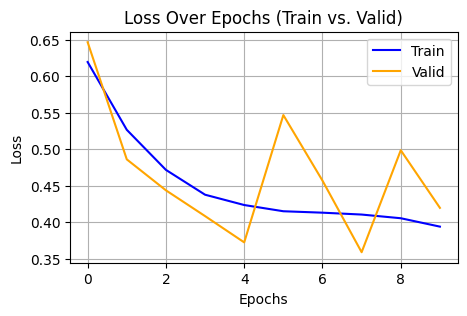

In [300]:
plt.figure(figsize=(5, 3))
plt.plot(train_loss, label='Train', color='blue', linestyle='-')
plt.plot(val_loss, label='Valid', color='orange', linestyle='-')

plt.title('Loss Over Epochs (Train vs. Valid)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [301]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9281    0.9229    0.9255      1077
           1     0.5538    0.5722    0.5628       180

    accuracy                         0.8727      1257
   macro avg     0.7409    0.7476    0.7442      1257
weighted avg     0.8745    0.8727    0.8736      1257



In [302]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

print("\n Evaluation Metrics:")
print(f" Accuracy:           {accuracy:.4f}")
print(f" Precision:          {precision:.4f}")
print(f" Recall:             {recall:.4f}")
print(f" F1 Score:           {f1:.4f}")
print(f" AUC-ROC:            {auc:.4f}")
print(f" Matthews Coef.:     {mcc:.4f}")


 Evaluation Metrics:
 Accuracy:           0.8727
 Precision:          0.5538
 Recall:             0.5722
 F1 Score:           0.5628
 AUC-ROC:            0.7476
 Matthews Coef.:     0.4885


Text(0.5, 1.0, 'ROC Curve')

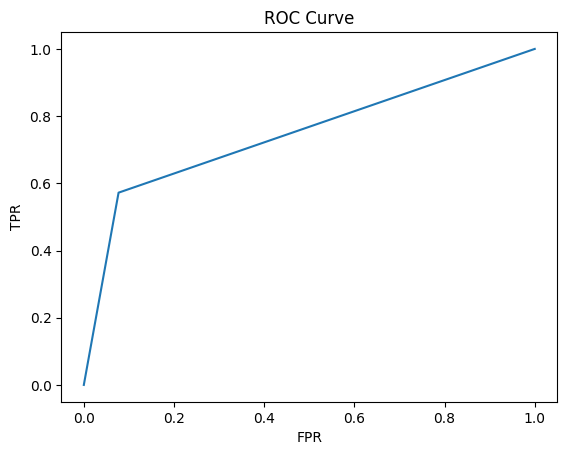

In [303]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")

<Axes: >

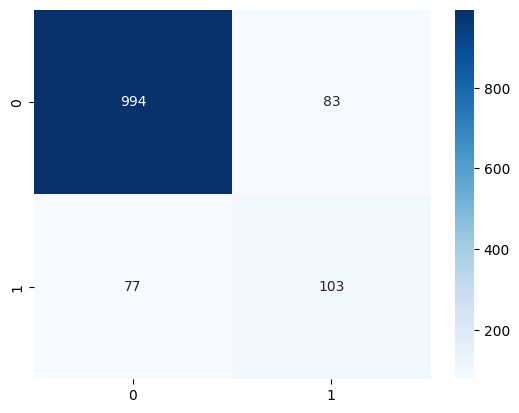

In [304]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

### Test for various window combinations (unfinished)

In [284]:
def preparate(X_tr, y_tr, X_te, y_te, windows_ob, windows_prior):
  for window_ob in windows_ob:
    for window_prior in windows_prior:
      X_tr, y_tr = cut_window(X_tr, y_tr, window_ob, window_prior)
      X_tr, y_tr = remove_nan_pacient(X_tr, y_tr)

      X_te, y_tr = cut_window(X_te, y_te, window_ob, window_prior)
      X_te, y_tr = remove_nan_pacient(X_te, y_te)

      X_tr = X_tr.sort_values(by=['Patient_ID', 'Hour'])
      y_tr = y_tr.sort_values(by=['Patient_ID', 'Hour'])

      X_te = X_te.sort_values(by=['Patient_ID', 'Hour'])
      y_te = y_te.sort_values(by=['Patient_ID', 'Hour'])

      X_tr, y_tr = to_3d_array(X_tr, y_tr)
      X_te, y_te = to_3d_array(X_te, y_te)

      result = train(X_tr, y_tr, X_te, y_te, window_ob, n_features, 32, 10)

  return result


In [269]:
def train(X_tr, y_tr, X_te, y_te, window_ob, n_features, qtd_unit=256, epoch=20):

    results = {
        'window_ob': [],
        'window_prior': [],
        'history': {
            'loss': [],
            'val_loss': []
        },
        'metrics': {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': [],
            'auc': [],
            'mcc': []
        },
        'confusion_matrix': []
    }

    classes = np.unique(y_tr)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_tr)
    class_weight_dict = dict(zip(classes, class_weights))

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model = Sequential([
    LSTM(qtd_unit, input_shape=(window_ob, n_features)),
    Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_tr, y_tr, epochs=epoch, batch_size=1, class_weight=class_weight_dict, validation_split=0.2, callbacks=[early_stop])

    y_pred = model.predict(X_te)
    y_pred = (y_pred > 0.5).astype(int)

    results['window_ob'].append(window_ob)
    results['history']['loss'].append(history.history['loss'])
    results['history']['val_loss'].append(history.history['val_loss'])
    results['metrics']['accuracy'].append(accuracy_score(y_test, y_pred))
    results['metrics']['precision'].append(precision_score(y_test, y_pred))
    results['metrics']['recall'].append(recall_score(y_test, y_pred))
    results['metrics']['f1'].append(f1_score(y_test, y_pred))
    results['metrics']['auc'].append(roc_auc_score(y_test, y_pred))
    results['metrics']['mcc'].append(matthews_corrcoef(y_test, y_pred))
    results['confusion_matrix'].append(confusion_matrix(y_test, y_pred))

    return results


In [270]:
windows_ob = [4, 6, 8, 10, 12]
windows_prior = [2, 4]

res = preparate(X_train_, y_train_, X_test_, y_test_, windows_ob, windows_prior)

<ipython-input-99-a743d54c5145>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train = df_train.groupby('Patient_ID', group_keys=False).apply(slice_group)
<ipython-input-99-a743d54c5145>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train = df_train.groupby('Patient_ID', group_keys=False).apply(slice_group)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 3930
'y' sizes: 1257
'sample_weight' sizes: 1257
